In [1]:
from PIL import Image
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.filters import gaussian
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np
from math import floor
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes
import json
from pycocotools import mask
from skimage import measure
import cv2
from matplotlib import rcParams


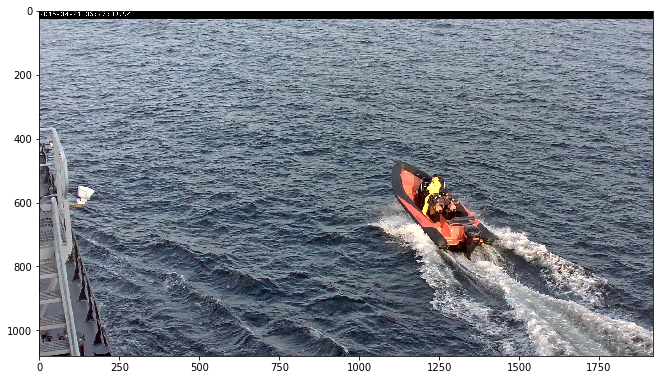

In [19]:
# Read in the image
im = Image.open("test_image.jpg")

# Convert image to numpy array
im = np.array(im)

# Display numpy array
plt.imshow(im)

Rows: 320
Cols: 337


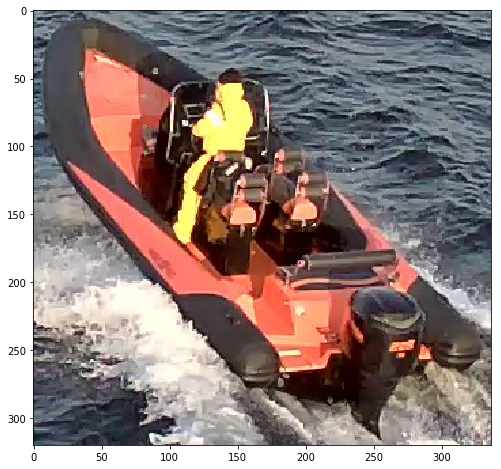

In [20]:
# Read in the image
im = Image.open("test_image.jpg")
original_rows, original_cols = im.size

# Declare bounding box
crop_rectangle = (1095, 468, 1432, 788)

# Crop the image around the bounding box
im = im.crop(crop_rectangle)

# Load pixel data from cropped image
pix = im.load()

cols, rows = im.size

print("Rows: {}".format(rows))
print("Cols: {}".format(cols))

# Convert cropped image to numpy array
im = np.array(im)
# im = gaussian(im, sigma=6)
original_shape = im.shape

# Display numpy array
plt.imshow(im)

In [21]:
# Load positive and negative histograms
RGB_Water_Histogram = np.load('RGB_Water_Histogram.npy')
RGB_Non_Water_Histogram = np.load('RGB_Non_Water_Histogram.npy')

In [22]:
# Get the height and width of the sample image
rows = np.shape(im)[0]
cols = np.shape(im)[1]

print("Rows: {}".format(rows))
print("Cols: {}".format(cols))

# Get histogram bins
histogram_bins = np.shape(RGB_Water_Histogram)[0]

# Get the factor based on the histogram bins
factor = 256 / histogram_bins

Rows: 320
Cols: 337


In [23]:
# Declare a results numpy array that contains only zeros
result = np.zeros((rows, cols))

/Users/brentredmon/Desktop/Computer-Vision-Final-Project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


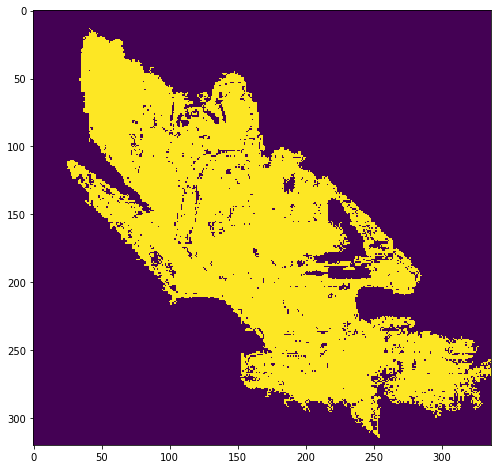

In [24]:
# Determine the probability of water given RGB and histograms representing water and non water

try:
    iterations = 4
    for row in range(rows):
        for col in range(cols):
    #         print(row)
    #         print(col)
    #         print("\n")
            red = float(pix[col, row][0])
            green = float(pix[col, row][1])
            blue = float(pix[col, row][2])

            red_index = floor(red / factor)
            green_index = floor(green / factor)
            blue_index = floor(blue / factor)

            water_value = RGB_Water_Histogram[red_index, green_index, blue_index]
            non_water_value = RGB_Non_Water_Histogram[red_index, green_index, blue_index]

            total = water_value + non_water_value

            if total is not 0:
                result[row, col] = water_value / total


    # Filter out points given threshold

    threshold = 0.48

    for row in range(rows):
        for col in range(cols):
            if result[row, col] < threshold:
                result[row, col] = 1
            else:
                result[row, col] = 0

    plt.imshow(result)

    # Get the largest connected component
    labels = label(result)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1

except:
    iterations = 2
    for row in range(rows):
        for col in range(cols):
    #         print(row)
    #         print(col)
    #         print("\n")
            red = float(pix[col, row][0])
            green = float(pix[col, row][1])
            blue = float(pix[col, row][2])

            red_index = floor(red / factor)
            green_index = floor(green / factor)
            blue_index = floor(blue / factor)

            water_value = RGB_Water_Histogram[red_index, green_index, blue_index]
            non_water_value = RGB_Non_Water_Histogram[red_index, green_index, blue_index]

            total = water_value + non_water_value

            if total is not 0:
                result[row, col] = water_value / total


    # Filter out points given threshold

    threshold = 0.48

    for row in range(rows):
        for col in range(cols):
            if result[row, col] < np.median(result):
                result[row, col] = 1
            else:
                result[row, col] = 0

    plt.imshow(result)

    # Get the largest connected component
    labels = label(result)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1

plt.imshow(largestCC)

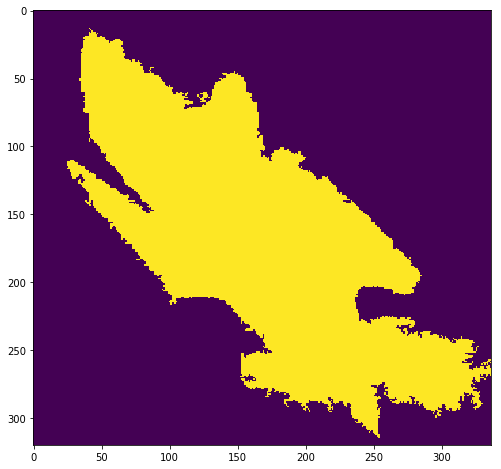

In [25]:
# Fill holes in the boat

largestCC = binary_fill_holes(largestCC)
plt.imshow(largestCC)

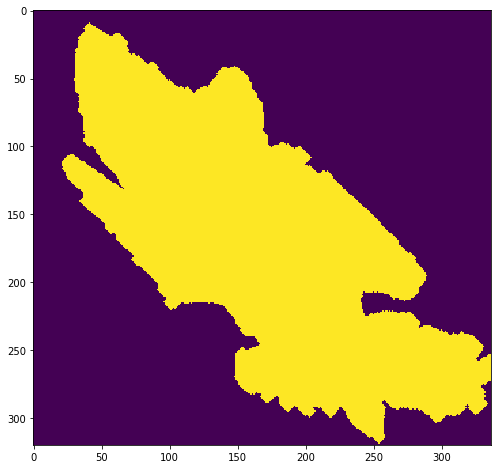

In [26]:
# Dialate to expand the mask

largestCC = binary_dilation(largestCC, iterations=iterations)
plt.imshow(largestCC)

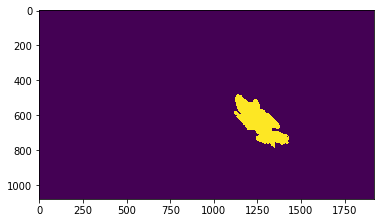

In [12]:
# Create numpy zeros array the same size as the original image before cropping
image_with_mask = np.zeros((original_cols, original_rows))

# Overlay binary mask onto zeros array
image_with_mask[crop_rectangle[1]:crop_rectangle[1] + rows, crop_rectangle[0]:crop_rectangle[0] + cols] = largestCC

plt.imshow(image_with_mask)

In [27]:
# Now that we have the mask, we can convert the mask into COCO JSON format

# Convert mask to type uint8
image_with_mask = np.array(image_with_mask, dtype=np.uint8)

fortran_ground_truth_binary_mask = np.asfortranarray(image_with_mask)
encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
ground_truth_area = mask.area(encoded_ground_truth)
ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
contours = measure.find_contours(image_with_mask, 0.5)

annotation = {
        "segmentation": [],
        "area": ground_truth_area.tolist(),
        "iscrowd": 0,
        "image_id": 123,
        "bbox": ground_truth_bounding_box.tolist(),
        "category_id": 1,
        "id": 1
    }

for contour in contours:
    contour = np.flip(contour, axis=1)
    segmentation = contour.ravel().tolist()
    annotation["segmentation"].append(segmentation)
    
print(json.dumps(annotation, indent=4))

{
    "segmentation": [
        [
            1349.0,
            786.5,
            1348.5,
            786.0,
            1348.0,
            785.5,
            1347.5,
            785.0,
            1347.0,
            784.5,
            1346.5,
            784.0,
            1346.0,
            783.5,
            1345.5,
            783.0,
            1345.0,
            782.5,
            1344.5,
            782.0,
            1344.0,
            781.5,
            1343.0,
            781.5,
            1342.5,
            782.0,
            1342.0,
            782.5,
            1341.5,
            782.0,
            1341.0,
            781.5,
            1340.5,
            781.0,
            1340.0,
            780.5,
            1339.5,
            780.0,
            1339.0,
            779.5,
            1338.5,
            779.0,
            1338.0,
            778.5,
            1337.0,
            778.5,
            1336.5,
            778.0,
            1336.0,
          

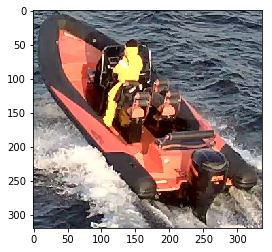

In [14]:
# Read in the image
im2 = Image.open("test_image.jpg")
original_rows, original_cols = im2.size

# Declare bounding box
crop_rectangle = (1095, 468, 1432, 788)

# Crop the image around the bounding box
im2 = im2.crop(crop_rectangle)

# Load pixel data
pix = im2.load()

rows, cols = im2.size

# Convert cropped image to numpy array
im2 = np.array(im2)
# im = gaussian(im, sigma=6)
original_shape = im2.shape

# Display numpy array
plt.imshow(im2)
crop_im = im2

# Get the height and width of the sample image
rows = np.shape(im2)[1]
cols = np.shape(im2)[0]



/Users/brentredmon/Desktop/Computer-Vision-Final-Project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


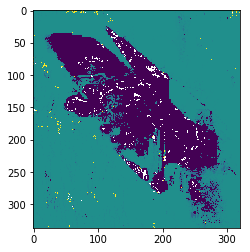

In [15]:
result = np.zeros((rows, cols))
RGB_Water_Histogram = np.load('RGB_Water_Histogram.npy')
RGB_Non_Water_Histogram = np.load('RGB_Non_Water_Histogram.npy')
histogram_bins = np.shape(RGB_Water_Histogram)[0]
factor = 256 / histogram_bins

for row in range(rows):
    for col in range(cols):
        red = float(pix[row, col][0])
        green = float(pix[row, col][1])
        blue = float(pix[row, col][2])
        
        red_index = floor(red / factor)
        green_index = floor(green / factor)
        blue_index = floor(blue / factor)
        
        water_value = RGB_Water_Histogram[red_index, green_index, blue_index]
        non_water_value = RGB_Non_Water_Histogram[red_index, green_index, blue_index]
        
        total = water_value + non_water_value
        
        if total is not 0:
            result[row, col] = water_value / total
    
plt.imshow(result)

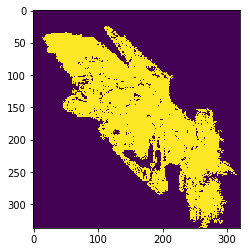

In [16]:
# Filter out points given threshold

threshold = 0.48

for row in range(rows):
    for col in range(cols):
        if result[row, col] < threshold:
            result[row, col] = 1
        else:
            result[row, col] = 0

# Get the largest connected component
labels = label(result)
assert( labels.max() != 0 ) # assume at least 1 CC
largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1

plt.imshow(largestCC)

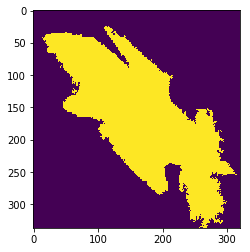

In [17]:
# Fill holes in the boat

largestCC = binary_fill_holes(largestCC)
plt.imshow(largestCC)
filled_mask = largestCC

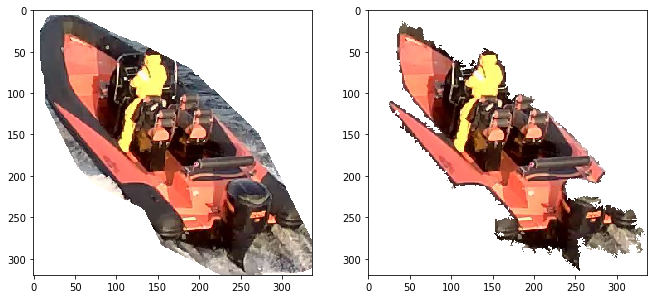

In [18]:
# Dialate to expand the mask (a bunch)
#hack hack hack hacky
largestCC = binary_dilation(largestCC, iterations=28)

rcParams['figure.figsize'] = 11 ,8
fig, ax = plt.subplots(1,2)

sharp_edges = crop_im
crop2 = crop_im

for row in range(rows):
    for col in range(cols):
        if largestCC[row, col] == 0:
            sharp_edges[col, row, :] = [0,0,0]

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

kernel2 = np.array([    [1,1,1,0,0,0,0,0,0],
                        [1,1,1,1,1,0,0,0,0],
                        [1,1,1,1,1,1,1,0,0],
                        [0,1,1,1,1,1,1,0,0],
                        [0,1,1,1,1,1,1,1,0],
                        [0,0,1,1,1,1,1,1,0],
                        [0,0,1,1,1,1,1,1,1],
                        [0,0,0,0,1,1,1,1,1],
                        [0,0,0,0,0,0,1,1,1]
                  ],dtype='uint8')


(thresh, binRed) = cv2.threshold(sharp_edges, 60, 255, cv2.THRESH_BINARY)
smoothed = cv2.morphologyEx(sharp_edges, cv2.MORPH_OPEN, kernel1, iterations=5)           
smoothed = cv2.morphologyEx(smoothed, cv2.MORPH_OPEN, kernel2, iterations=17) 

for row in range(rows):
    for col in range(cols):
            if smoothed[col, row, 0]  + smoothed[col, row, 1] + smoothed[col, row, 2] < 1:
                crop_im[col, row, :] = [255,255,255]

ax[0].imshow(crop_im)
                

for row in range(rows):
    for col in range(cols):
            if filled_mask[row, col] == 0:
                crop2[col, row, :] = [255,255,255]
                
ax[1].imshow(crop2)